### Problem Statement "AI-Enhanced Product Photoshoot Visuals and Filter"
#### Problem Description:
In the fast-paced world of e-commerce, the visual presentation of products is crucial for attracting customers and
driving sales. Your challenge is to develop an innovative AI solution that generates stunning product
photoshoot visuals and implements a filter to identify specific products within a given list of objects. (Shoe,
Sneaker, Bottle, Cup, Sandal, Perfume, Toy, Sunglasses, Car, Water Bottle, Chair, Office Chair, Can, Cap, Hat,
Couch, Wristwatch, Glass, Bag, Handbag, Baggage, Suitcase, Headphones, Jar, Vase )

## Key Objectives

### Generative AI for Visuals:
- Implement a generative AI model capable of creating realistic and visually appealing product photoshoot visuals.
- The model should be able to understand and simulate various lighting conditions, backgrounds, and angles
commonly used in product photography.


 ### Product Recognition Filter:
- Develop an AI filter that can identify and isolate specific products within a given image dataset.
- The filter should be trained to recognize a predefined set of products (e.g., apparel, electronics, accessories) and
enhance their features while maintaining the overall image integrity.

### Exclusion of Non-Relevant Images:
- Implement a mechanism to filter out images that do not contain any of the specified products. This ensures that only
relevant visuals are processed and enhanced

## Install Requirements

In [478]:
!pip install diffusers --upgrade
!pip install invisible_watermark transformers accelerate safetensors
!pip install matplotlib
!pip install ultralytics[explorer] openai
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install opencv-python-headless pillow

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jx3o52jv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-jx3o52jv
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


## Import Libraries

In [480]:
from diffusers import DiffusionPipeline, StableDiffusionImageVariationPipeline, StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
import requests
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
import PIL
from PIL import Image
import ultralytics
from ultralytics import YOLO
from huggingface_hub import from_pretrained_keras
import tensorflow as tf
import numpy as np
import clip
import os
import cv2

In [482]:
ultralytics.checks()

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 56.0/201.2 GB disk)


# **Pipeline to generate the product**



Implement a generative AI model capable of creating realistic and visually appealing product photoshoot visuals.

**Stable Diffusion XL base 1.0**
[stabilityai/stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)

`Diffusion Models > GANs`


In [481]:
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
base.to("cuda")
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "stabilityai/stable-diffusion-xl-refiner-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": false,
  "image_encoder": [
    null,
    null
  ],
  "requires_aesthetics_score": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    null,
    null
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [483]:
n_steps = 40
high_noise_frac = 0.8

In [484]:
prompt = "Create a highly detailed and photorealistic image of a single full car"

image = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images
product_image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [485]:
product_image.save("product.png")

## View sample Generated product output

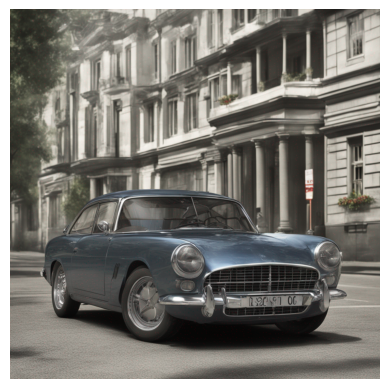

In [486]:
plt.imshow(product_image)
plt.axis('off')
plt.show()

# **Pipeline to generate variations**

The model should be able to understand and simulate various lighting conditions, backgrounds, and angles
commonly used in product photography.

[instruct-pix2pix](https://www.timothybrooks.com/instruct-pix2pix)


**InstructPix2Pix is a model that edits images based on natural language instructions, trained on a dataset created by combining the capabilities of GPT-3 and a text-to-image model like Stable Diffusion. It performs quick, generalizable edits without the need for per-example tuning.**



In [487]:
model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler(beta_start=0.0001, beta_end=0.02, num_train_timesteps=1000)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [488]:
product_image = PIL.ImageOps.exif_transpose(product_image)
product_image = product_image.convert("RGB")

  0%|          | 0/50 [00:00<?, ?it/s]

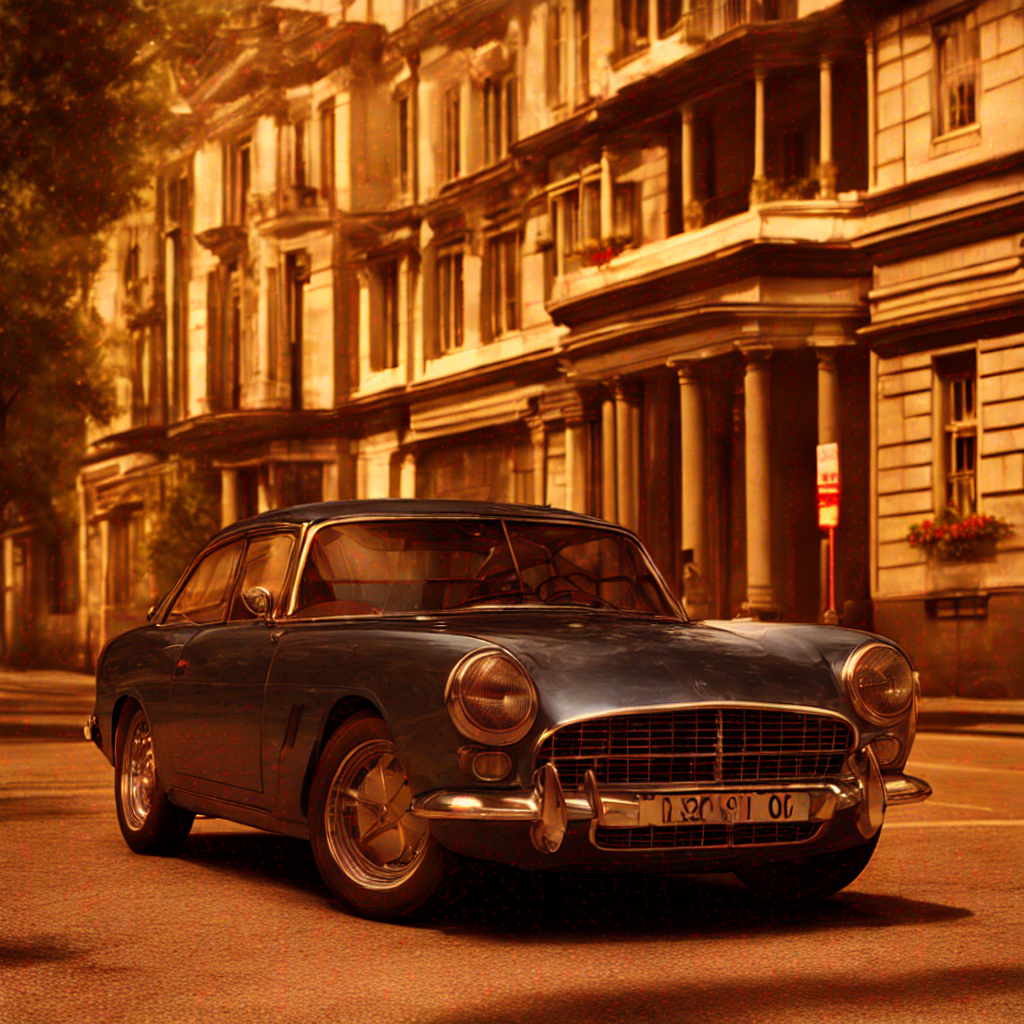

In [494]:
prompt = "simulate sunset lighting conditions"
images = pipe(prompt, num_images_per_prompt=3, image=product_image, num_inference_steps=50, image_guidance_scale=3).images
images[2]

### Save the Variation images int he output directory

In [496]:
output_directory = "product_variations"
os.makedirs(output_directory, exist_ok=True)

In [495]:
for i, image in enumerate(images):
    image_filename = f"result_{i}.jpg"
    image.save(os.path.join(output_directory, image_filename))

### view variations

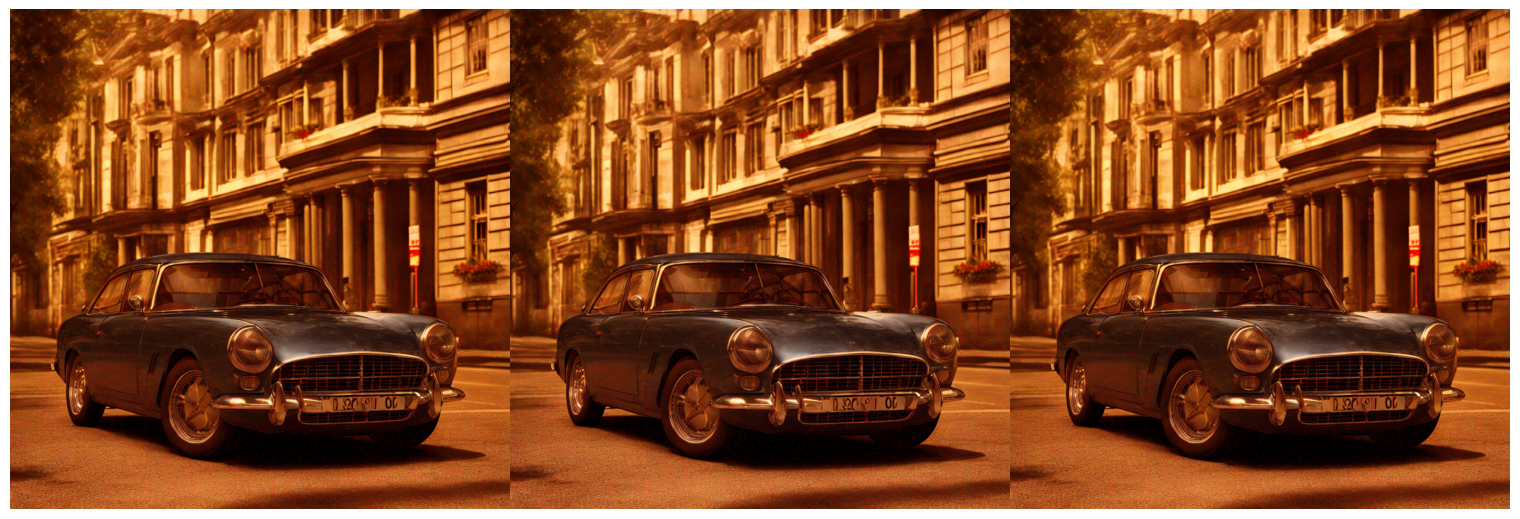

In [497]:
fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(15, 5))
fig.subplots_adjust(0,0,1,1)

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout(pad=0)
plt.show()

# **Product Isolation**

1.   Develop an AI filter that can identify and isolate specific products within a given image dataset.
2.   The filter should be trained to recognize a predefined set of products.

[YOLOv8](https://github.com/ultralytics/ultralytics)

**YOLOv8 advances the YOLO series with enhancements for speed, accuracy, and usability across various tasks like object detection, segmentation, classification, and pose estimation.**



In [498]:
from ultralytics.data.explorer import plot_query_result

In [499]:
model = YOLO("yolov8x.pt")
detection_outputs = model.predict(source="/content/product_variations")


image 1/3 /content/product_variations/result_0.jpg: 640x640 1 car, 1 potted plant, 18.1ms
image 2/3 /content/product_variations/result_1.jpg: 640x640 1 car, 1 potted plant, 20.7ms
image 3/3 /content/product_variations/result_2.jpg: 640x640 1 car, 1 potted plant, 18.6ms
Speed: 4.9ms preprocess, 19.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


In [500]:
for detection_output in detection_outputs:
  print(detection_output.path)
  print(detection_output.boxes.xywh)

/content/product_variations/result_0.jpg
tensor([[507.2414, 710.0590, 849.7797, 422.3647],
        [960.5413, 538.0387, 108.9058,  51.6633]], device='cuda:0')
/content/product_variations/result_1.jpg
tensor([[507.2863, 710.1759, 849.2672, 422.4805],
        [960.5834, 537.8349, 109.2324,  54.0351]], device='cuda:0')
/content/product_variations/result_2.jpg
tensor([[507.3788, 710.3190, 848.3081, 423.5504],
        [961.0338, 537.0966, 109.3508,  54.1379]], device='cuda:0')


# **Product Enhancement**

Enhance their features while maintaining the overall image integrity.

[OpenCV](https://opencv.org/)

**OpenCV is an open-source computer vision and machine learning software library that provides a comprehensive set of tools for image processing**

In [501]:
def enhance_image(image_path, bbox_tensor, count):
    pil_image = Image.open(image_path)
    cv_image = np.array(pil_image)
    cv_image = cv_image[:, :, ::-1].copy()

    bbox = bbox_tensor.detach().cpu().numpy()[0]
    x_center, y_center, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])

    x = int(x_center - (w / 2))
    y = int(y_center - (h / 2))

    rows, cols, _ = cv_image.shape

    Y, X = np.ogrid[:rows, :cols]
    distance_from_center = np.sqrt((X - x_center)**2 + (Y - y_center)**2)
    initial_mask = np.clip((1 - distance_from_center / distance_from_center.max()), 0, 1)

    radial_mask = initial_mask / initial_mask.max()

    vignette = cv_image.astype(np.float32) * radial_mask[:, :, np.newaxis]

    final_image = Image.fromarray(np.uint8(vignette)[:, :, ::-1])
    final_image.save("product_enhanced/result_" + str(count) + ".jpg")


In [502]:
counter = 0
for detection_output in detection_outputs:
  counter = counter + 1
  print(detection_output.path)
  print(detection_output.boxes.xywh)
  enhance_image(detection_output.path, detection_output.boxes.xywh, str(counter))

/content/product_variations/result_0.jpg
tensor([[507.2414, 710.0590, 849.7797, 422.3647],
        [960.5413, 538.0387, 108.9058,  51.6633]], device='cuda:0')
/content/product_variations/result_1.jpg
tensor([[507.2863, 710.1759, 849.2672, 422.4805],
        [960.5834, 537.8349, 109.2324,  54.0351]], device='cuda:0')
/content/product_variations/result_2.jpg
tensor([[507.3788, 710.3190, 848.3081, 423.5504],
        [961.0338, 537.0966, 109.3508,  54.1379]], device='cuda:0')


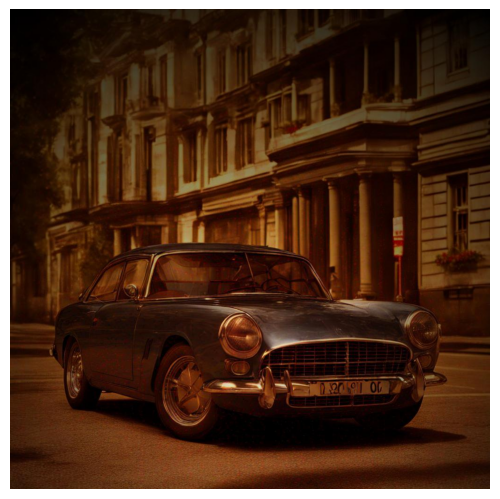

In [503]:
img = Image.open("product_enhanced/result_1.jpg")
plt.imshow(img)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# **Exclusion of Non-Relevant Images**

Implement a mechanism to filter out images that do not contain any of the specified products. This ensures that only
relevant visuals are processed and enhanced.

[ViT-B/32](https://huggingface.co/sentence-transformers/clip-ViT-B-32)

The CLIP-ViT-B-32 model is part of the CLIP (Contrastive Language–Image Pretraining) family, developed by OpenAI, which combines Vision Transformers (ViT) with a language model.

**Why ViT?**
*   Zero-Shot Learning
*   Contextual Understanding
*   Transfer Learning

In [504]:
directory = "/content/product_enhanced"
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [505]:
text_tokens = clip.tokenize(["car"]).to(device)

In [506]:
for filename in os.listdir(directory):
    if filename.endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(directory, filename)
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text_tokens)

        similarity = torch.nn.functional.cosine_similarity(text_features, image_features)
        is_match = similarity > 0.5

        if is_match.item():
            # os.remove(image_path)
            print(f"Ignored {filename} as it does not match the required product.")
        else:
            print("requirement matched")

requirement matched
requirement matched
requirement matched
